In [106]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
import lightgbm as lgb
import os
import shutil
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns = 500
#import pandas_profiling

In [7]:
# ## plotly 
# import plotly.plotly as py
# import plotly.graph_objs as go
# from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
# init_notebook_mode(connected=True)

In [8]:
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:50].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    #plt.savefig('lgbm_importances01.png')

In [76]:
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')

## FE

In [77]:
train_df.tail(10)

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
199990,train_199990,1,14.1475,1.8568,11.0066,3.6779,12.1944,-16.5936,5.3217,14.8508,3.3377,6.1650,6.1414,0.0827,14.0400,1.6150,7.5366,14.4789,6.2584,2.1186,26.7359,0.5702,4.0029,15.5389,5.4881,2.4573,18.2939,13.8830,-16.1930,-1.8986,4.8970,7.5907,0.8798,8.5026,4.3286,12.8019,11.9591,2.9620,-4.4218,5.8075,6.2756,-1.8136,-24.1308,24.6378,11.9017,11.6704,11.5972,35.0815,9.5150,-5.1348,37.5782,13.2321,12.6700,29.2393,-6.1634,6.5313,0.4095,7.6697,17.3582,4.8764,-5.3656,7.7960,8.2764,-22.6021,1.6359,-5.1907,6.5715,1.6882,6.2847,3.3086,5.0167,-7.6718,23.4462,0.7742,1.1682,31.0228,32.3939,16.7054,10.3803,15.6047,4.7141,13.5369,-2.3319,11.8592,0.9950,17.4239,-0.8730,13.8346,10.0802,10.3809,7.0715,12.7042,-25.1787,7.1149,12.2700,10.9310,7.7426,0.4302,13.6463,38.9630,2.3068,-0.3915,-8.5204,20.1458,19.0598,1.4362,11.6263,4.1638,7.5614,19.4758,14.2716,16.1327,3.1721,9.3863,4.1246,4.7095,2.6171,4.9913,2.1080,31.6905,-1.7796,0.4008,22.8108,9.0540,0.5427,-6.9109,6.0711,12.7660,12.7326,3.8427,1.2784,19.1283,12.6645,0.4973,8.1403,6.4378,-8.2097,1.5164,34.2795,14.7229,5.3334,-9.0510,-3.4490,-6.8524,17.0059,11.4479,7.6751,3.8062,9.9805,-11.8864,3.8402,21.7955,17.6339,6.8544,10.9870,16.7374,4.9328,-8.8372,15.2210,-9.6098,25.5304,7.5533,12.4722,5.7143,4.3119,11.5818,-1.0976,15.9085,3.3110,-0.8404,5.9175,4.7656,-7.7289,6.2246,26.4941,3.7733,31.7617,8.5447,-2.1253,9.6392,-2.7775,-2.2930,-0.4321,8.2347,-16.8808,6.8203,15.0222,3.3871,9.8074,-36.3302,16.0983,0.8156,-6.4708,4.7287,1.9034,7.2324,20.6047,1.7170,-4.0032,9.1627,13.8077,-1.9646
199991,train_199991,0,9.9909,2.5523,11.9653,6.3958,13.5497,-9.5293,6.0864,14.1789,-2.1245,9.8862,-3.1886,-0.2491,13.9248,13.8947,9.6829,13.9033,10.2258,5.9237,17.3947,1.9836,9.2717,28.8883,5.6900,3.1928,8.9120,13.7650,-11.6627,-1.4927,5.4689,1.3060,2.4111,12.4307,3.1743,14.9818,11.8855,1.8232,9.2384,5.5283,9.1446,5.1439,-3.5793,1.0812,10.7423,11.6788,1.9277,-19.9550,6.4090,-23.0383,-5.0783,16.4067,13.4490,3.3566,7.4365,5.1999,4.9993,6.6391,15.4445,6.4535,2.7636,9.3584,22.6203,1.7745,1.2965,-1.7242,5.1655,-3.2149,6.5610,16.0365,5.0258,-6.1367,48.5375,0.8261,3.0558,16.2346,39.7911,19.4477,10.8329,15.5222,4.4408,13.5912,1.9444,18.0211,-23.2330,5.7972,-11.0950,13.2983,4.5397,7.8958,3.0405,-4.4533,-25.4294,6.8083,21.1329,10.9765,11.9918,0.3610,21.2432,-2.4605,2.3231,-3.0889,2.6465,2.2822,28.6410,1.8103,12.2662,4.9371,9.1332,5.7253,14.1759,14.4442,9.2293,7.8426,1.8774,8.9777,1.8659,4.1717,4.7503,35.5995,-10.8612,5.7606,22.9226,12.3712,4.2567,9.2771

In [78]:
train_len = train_df.shape[0]
merged_df = pd.concat([train_df, test_df],sort=False)


var_list = [f for f in merged_df.columns if 'var' in f]
new_var_list = [f+'_rank' for f in var_list]

In [79]:

#merged_df[new_var_list] = merged_df[var_list].apply(lambda x: pd.qcut(x, q=2, labels=False))


merged_df[new_var_list] = merged_df[var_list].rank(pct=True)

train_df = merged_df.iloc[:train_len]
test_df = merged_df.iloc[train_len:]

# del merged_df
# gc.collect()

In [86]:
#merged_df['target'] = np.where(merged_df.target.isna(),3,merged_df.target)
merged_df.groupby('target')[var_list].mean()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
target,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.0,10.626681,-1.695770,10.665876,6.788979,11.072412,-5.146736,5.389620,16.549306,0.262347,7.584907,0.398410,-3.291479,14.028392,8.615764,7.542364,14.570748,9.326326,-5.698669,15.129914,12.408389,13.326894,17.418103,4.247785,3.024026,10.548447,13.666224,-4.178694,-1.137611,5.539248,5.049780,-7.689438,10.411541,-0.539278,14.838196,11.443788,3.779194,2.227270,5.863121,10.640744,0.668519,-6.862568,9.302433,11.224302,11.572909,9.045045,-12.556114,11.321047,-12.503504,14.581677,16.602122,12.744200,13.357783,-2.575063,5.992363,1.181542,12.713185,16.670579,6.276124,3.212497,8.934109,12.146777,-11.975518,0.864765,0.676438,6.376013,0.968699,5.785376,11.833250,5.018922,-3.342466,24.339961,0.666760,0.657700,19.627010,19.424857,16.930805,6.215158,19.089268,5.317329,14.398815,5.938240,14.781217,-3.535250,1.082746,-2.615932,18.394744,5.722424,11.419346,8.720142,3.678356,-16.677375,6.985494,12.804355,10.563109,10.956329,-0.092343,14.391779,18.475315,1.752987,-0.782632,-6.607317,13.428646,22.347767,1.568479,11.527357,4.237421,8.596790,17.897930,14.226997,18.530675,5.431102,6.302948,3.305242,8.156932,3.089842,2.257686,2.415508,16.090717,-5.423827,2.989544,24.565218,11.333391,1.266336,7.159040,4.268882,12.486164,13.201965,0.892539,-1.157075,15.468444,12.248829,0.549612,7.811608,6.806422,-4.861527,-4.330622,22.980935,17.532856,1.182907,7.950512,3.398596,2.964264,12.019446,12.344686,8.641093,4.801034,10.394760,-3.400584,3.994388,5.460487,16.838938,10.105088,7.644020,16.732684,7.051416,-2.145962,13.215975,-4.874326,17.924650,10.202228,24.277974,5.632989,5.347406,10.946221,-2.946693,19.409346,2.970474,-4.231423,4.922471,5.641983,-0.075908,-0.858512,19.927197,-0.761772,20.357774,11.619644,-2.818344,11.915324,-0.957623,2.544666,-2.796515,10.079230,0.740672,8.777265,12.606196,-3.983345,9.002707,-10.392583,15.422021,0.743065,3.149130,7.390800,1.949017,3.355403,18.017716,-0.155601,2.260297,8.919032,15.924058,-3.415273
1.0,11.156418,-1.017613,11.156633,6.864113,11.131337,-4.336522,5.581966,16.514917,0.479432,7.409064,0.357916,-2.834888,13.984464,7.764618,7.495020,14.594414,9.395369,-5.679385,16.265343,12.708704,12.968654,15.823715,4.821429,2.979384,10.906222,13.678882,-2.949112,-1.140560,5.476866,5.090517,-7.672537,10.227496,-0.276639,14.200831,11.348866,4.409162,1.828816,5.920623,10.65454

In [69]:
test_df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,...,var_75_qcut_2,var_76_qcut_2,var_77_qcut_2,var_78_qcut_2,var_79_qcut_2,var_80_qcut_2,var_81_qcut_2,var_82_qcut_2,var_83_qcut_2,var_84_qcut_2,var_85_qcut_2,var_86_qcut_2,var_87_qcut_2,var_88_qcut_2,var_89_qcut_2,var_90_qcut_2,var_91_qcut_2,var_92_qcut_2,var_93_qcut_2,var_94_qcut_2,var_95_qcut_2,var_96_qcut_2,var_97_qcut_2,var_98_qcut_2,var_99_qcut_2,var_100_qcut_2,var_101_qcut_2,var_102_qcut_2,var_103_qcut_2,var_104_qcut_2,var_105_qcut_2,var_106_qcut_2,var_107_qcut_2,var_108_qcut_2,var_109_qcut_2,var_110_qcut_2,var_111_qcut_2,var_112_qcut_2,var_113_qcut_2,var_114_qcut_2,var_115_qcut_2,var_116_qcut_2,var_117_qcut_2,var_118_qcut_2,var_119_qcut_2,var_120_qcut_2,var_121_qcut_2,var_122_qcut_2,var_123_qcut_2,var_124_qcut_2,var_125_qcut_2,var_126_qcut_2,var_127_qcut_2,var_128_qcut_2,var_129_qcut_2,var_130_qcut_2,var_131_qcut_2,var_132_qcut_2,var_133_qcut_2,var_134_qcut_2,var_135_qcut_2,var_136_qcut_2,var_137_qcut_2,var_138_qcut_2,var_139_qcut_2,var_140_qcut_2,var_141_qcut_2,var_142_qcut_2,var_143_qcut_2,var_144_qcut_2,var_145_qcut_2,var_146_qcut_2,var_147_qcut_2,var_148_qcut_2,var_149_qcut_2,var_150_qcut_2,var_151_qcut_2,var_152_qcut_2,var_153_qcut_2,var_154_qcut_2,var_155_qcut_2,var_156_qcut_2,var_157_qcut_2,var_158_qcut_2,var_159_qcut_2,var_160_qcut_2,var_161_qcut_2,var_162_qcut_2,var_163_qcut_2,var_164_qcut_2,var_165_qcut_2,var_166_qcut_2,var_167_qcut_2,var_168_qcut_2,var_169_qcut_2,var_170_qcut_2,var_171_qcut_2,var_172_qcut_2,var_173_qcut_2,var_174_qcut_2,var_175_qcut_2,var_176_qcut_2,var_177_qcut_2,var_178_qcut_2,var_179_qcut_2,var_180_qcut_2,var_181_qcut_2,var_182_qcut_2,var_183_qcut_2,var_184_qcut_2,var_185_qcut_2,var_186_qcut_2,var_187_qcut_2,var_188_qcut_2,var_189_qcut_2,var_190_qcut_2,var_191_qcut_2,var_192_qcut_2,var_193_qcut_2,var_194_qcut_2,var_195_qcut_2,var_196_qcut_2,var_197_qcut_2,var_198_qcut_2,var_199_qcut_2
0,test_0,NaN,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,8.8100,-2.0248,-4.3554,13.9696,0.3458,7.5408,14.5001,7.7028,-19.0919,15.5806,16.1763,3.7088,18.8064,1.5899,3.0654,6.4509,14.1192,-9.4902,-2.1917,5.7107,3.7864,-1.7981,9.2645,2.0657,12.7753,11.3334,8.1462,-0.0610,3.5331,9.7804,8.7625,-15.6305,18.8766,11.2864,11.8362,13.3680,-31.9891,12.1776,8.7714,17.2011,16.8508,13.0534,14.4069,-4.8525,7.3213,-0.5259,16.6365,19.3036,6.4129,-5.3948,9.3269,11.9314,-3.5750,-0.7706,0.8705,6.9282,2.8914,5.9744,17.4851,5.0125,-1.4230,33.3401,0.8018,-4.7906,30.2708,26.8339,21.7205,7.3075,14.0810,3.1192,17.4265,9.4883,16.9060,14.5117,10.0276,-0.9706,20.4588,4.7945,20.4160,13.1633,7.9307,-7.6509,7.0834,15.2324,10.1416,5.9156,-0.5775,5.7600,30.3238,2.1251,1.8585,-9.2198,17.3089,30.9548,1.4918,12.8721,3.4902,8.2856,11.9794,14.0176,15.0763,3.7662,6.0426,4.4243,14.1799,2.0921,1.5493,3.2206,0.0172,-6.6602,8.4785,42.0248,11.4164,0.4564,...,1,1,0,0,1,1,1,1,1,1,1,0,1,1,1,1,1,1,0,0,0,0,1,1,1,0,1,1,0,1,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,1,1,0,1,0,1,1,1,0,1,1,1,1,1,1,1,0,1,0,0,0,0,1,1,1,0,1,0,1,1,1,0,0,0,1,1,0,1,0,1,0,0,0,0,0,1,0,1,0,0,1,1,1,1,0,1,1,0,0,0,0,1,0,0,1,1,1,0,0,1,0,1,0,0,0,1,1,1,0,0
1,test_1,NaN,8.5304,1.2543,11.3047,5.1858,9.1974,-4.01

## Model

In [70]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

n_folds = 5
random_seed = 26
model = 'rank_pct_1_0'


model_name = "{0}_{1}_folds".format(model, n_folds)
print("Model: {}".format(model_name))

Model: rank_pct_1_0_5_folds


In [71]:
#feats = train_df.iloc[:,2:].columns.tolist();feats

#exclusion = ['ID_code', 'target']+ rank_var_list
exclusion = ['ID_code', 'target'] 

feats = [c for c in train_df.columns if c not in exclusion]

#cat_feats = [c for c in feats if c not in var_list]

In [72]:
feats

['var_0',
 'var_1',
 'var_2',
 'var_3',
 'var_4',
 'var_5',
 'var_6',
 'var_7',
 'var_8',
 'var_9',
 'var_10',
 'var_11',
 'var_12',
 'var_13',
 'var_14',
 'var_15',
 'var_16',
 'var_17',
 'var_18',
 'var_19',
 'var_20',
 'var_21',
 'var_22',
 'var_23',
 'var_24',
 'var_25',
 'var_26',
 'var_27',
 'var_28',
 'var_29',
 'var_30',
 'var_31',
 'var_32',
 'var_33',
 'var_34',
 'var_35',
 'var_36',
 'var_37',
 'var_38',
 'var_39',
 'var_40',
 'var_41',
 'var_42',
 'var_43',
 'var_44',
 'var_45',
 'var_46',
 'var_47',
 'var_48',
 'var_49',
 'var_50',
 'var_51',
 'var_52',
 'var_53',
 'var_54',
 'var_55',
 'var_56',
 'var_57',
 'var_58',
 'var_59',
 'var_60',
 'var_61',
 'var_62',
 'var_63',
 'var_64',
 'var_65',
 'var_66',
 'var_67',
 'var_68',
 'var_69',
 'var_70',
 'var_71',
 'var_72',
 'var_73',
 'var_74',
 'var_75',
 'var_76',
 'var_77',
 'var_78',
 'var_79',
 'var_80',
 'var_81',
 'var_82',
 'var_83',
 'var_84',
 'var_85',
 'var_86',
 'var_87',
 'var_88',
 'var_89',
 'var_90',
 'var_91'

Current Fold: 1
AUC = 0.8910380146735819
Current Fold: 2
AUC = 0.8910046222571032
Current Fold: 3
AUC = 0.8953666630715239
Current Fold: 4
AUC = 0.8947465353910227
Current Fold: 5
AUC = 0.8943061522249581
Overall AUC = 0.8930529374503305
Saving submission file


C:\Users\TanQ\AppData\Local\Continuum\anaconda3\envs\work\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


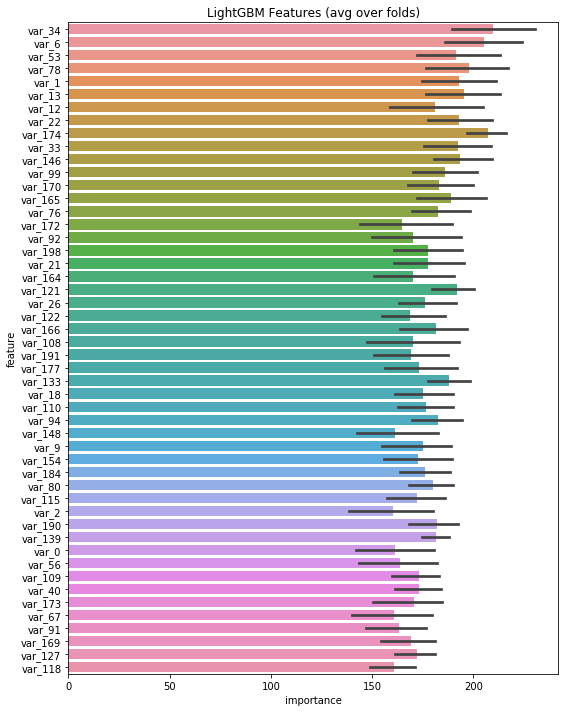

In [73]:
clfs = []
folds = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=random_seed)
oof_preds = np.zeros((len(train_df), 1))
test_preds = np.zeros((len(test_df), 1))


X = train_df[feats]
y = train_df['target']
X_test = test_df[feats]
test_ids = test_df.ID_code.values


parameters = {
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    #'scale_pos_weight': 400,
    #'device' : 'gpu' ,
    'boosting': 'gbdt',
    'num_leaves': 31, #31
    'feature_fraction': 0.5,
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    'learning_rate': 0.05, #0.05
    'verbose': 30
    #'min_data_in_leaf': 200
}

feature_importance_df = pd.DataFrame()
for fold_, (trn_, val_) in enumerate(folds.split(X, y)):
    print("Current Fold: {}".format(fold_+1))
    trn_x, trn_y = X.iloc[trn_, :], y[trn_]
    val_x, val_y = X.iloc[val_, :], y[val_]


    trn_lgb = lgb.Dataset(trn_x, trn_y)
    val_lgb = lgb.Dataset(val_x, val_y)
    clf = lgb.train(parameters,
                     train_set=trn_lgb,
                     #valid_sets=[valid_data_lgb,holdout_data_lgb],
                     valid_sets=[trn_lgb, val_lgb],
                     num_boost_round=3000,
                     early_stopping_rounds=50,
                     verbose_eval=False)
    


    val_pred = clf.predict(val_x)
    test_fold_pred = clf.predict(X_test)

    print("AUC = {}".format(roc_auc_score(val_y, val_pred)))
    oof_preds[val_, :] = val_pred.reshape((-1, 1))
    test_preds += test_fold_pred.reshape((-1, 1))
    
   # print('getting feature importance')
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feats
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    
test_preds /= n_folds
roc_score = roc_auc_score(y, oof_preds.ravel())
print("Overall AUC = {}".format(roc_score))


print("Saving submission file")
sample = pd.read_csv('../data/sample_submission.csv')
sample.target = test_preds.astype(float)
sample.ID_code = test_ids
sample.to_csv('../submissions/{}_{}.csv'.format(model_name,str(roc_score)), index=False)

display_importances(feature_importance_df)


In [74]:
%%javascript
var nb = IPython.notebook;
var kernel = IPython.notebook.kernel;
var command = "NOTEBOOK_FULL_PATH = '" + nb.base_url + nb.notebook_path + "'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [75]:


shutil.copyfile(os.path.basename(NOTEBOOK_FULL_PATH), 
                             '../models/{}_{}.ipynb'.format(model_name, str(roc_score)))


'../models/rank_pct_1_0_5_folds_0.8930529374503305.ipynb'

## Post-model evaluation

In [88]:
y.shape

(200000,)

In [90]:
oof_preds

array([[0.02178814],
       [0.75473365],
       [0.02379914],
       ...,
       [0.33932852],
       [0.25191656],
       [0.05398939]])

In [91]:
train_df['pred'] = oof_preds

C:\Users\TanQ\AppData\Local\Continuum\anaconda3\envs\work\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [92]:
train_df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,...,var_76_rank,var_77_rank,var_78_rank,var_79_rank,var_80_rank,var_81_rank,var_82_rank,var_83_rank,var_84_rank,var_85_rank,var_86_rank,var_87_rank,var_88_rank,var_89_rank,var_90_rank,var_91_rank,var_92_rank,var_93_rank,var_94_rank,var_95_rank,var_96_rank,var_97_rank,var_98_rank,var_99_rank,var_100_rank,var_101_rank,var_102_rank,var_103_rank,var_104_rank,var_105_rank,var_106_rank,var_107_rank,var_108_rank,var_109_rank,var_110_rank,var_111_rank,var_112_rank,var_113_rank,var_114_rank,var_115_rank,var_116_rank,var_117_rank,var_118_rank,var_119_rank,var_120_rank,var_121_rank,var_122_rank,var_123_rank,var_124_rank,var_125_rank,var_126_rank,var_127_rank,var_128_rank,var_129_rank,var_130_rank,var_131_rank,var_132_rank,var_133_rank,var_134_rank,var_135_rank,var_136_rank,var_137_rank,var_138_rank,var_139_rank,var_140_rank,var_141_rank,var_142_rank,var_143_rank,var_144_rank,var_145_rank,var_146_rank,var_147_rank,var_148_rank,var_149_rank,var_150_rank,var_151_rank,var_152_rank,var_153_rank,var_154_rank,var_155_rank,var_156_rank,var_157_rank,var_158_rank,var_159_rank,var_160_rank,var_161_rank,var_162_rank,var_163_rank,var_164_rank,var_165_rank,var_166_rank,var_167_rank,var_168_rank,var_169_rank,var_170_rank,var_171_rank,var_172_rank,var_173_rank,var_174_rank,var_175_rank,var_176_rank,var_177_rank,var_178_rank,var_179_rank,var_180_rank,var_181_rank,var_182_rank,var_183_rank,var_184_rank,var_185_rank,var_186_rank,var_187_rank,var_188_rank,var_189_rank,var_190_rank,var_191_rank,var_192_rank,var_193_rank,var_194_rank,var_195_rank,var_196_rank,var_197_rank,var_198_rank,var_199_rank,pred
0,train_0,0.0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,2.9252,3.1821,14.0137,0.5745,8.7989,14.5691,5.7487,-7.2393,4.2840,30.7133,10.5350,16.2191,2.5791,2.4716,14.3831,13.4325,-5.1488,-0.4073,4.9306,5.9965,-0.3085,12.9041,-3.8766,16.8911,11.1920,10.5785,0.6764,7.8871,4.6667,3.8743,-5.2387,7.3746,11.5767,12.0446,11.6418,-7.0170,5.9226,-14.2136,16.0283,5.3253,12.9194,29.0460,-0.6940,5.1736,-0.7474,14.8322,11.2668,5.3822,2.0183,10.1166,16.1828,4.9590,2.0771,-0.2154,8.6748,9.5319,5.8056,22.4321,5.0109,-4.7010,21.6374,0.5663,5.1999,8.8600,43.1127,18.3816,-2.3440,23.4104,6.5199,12.1983,13.6468,13.8372,1.3675,2.9423,-4.5213,21.4669,9.3225,16.4597,7.9984,-1.7069,-21.4494,6.7806,11.0924,9.9913,14.8421,0.1812,8.9642,16.2572,2.1743,-3.4132,9.4763,13.3102,26.5376,1.4403,14.7100,6.0454,9.5426,17.1554,14.1104,24.3627,2.0323,6.7602,3.9141,-0.4851,2.5240,1.5093,2.5516,15.5752,-13.4221,7.2739,16.0094,9.7268,0.8897,...,0.149740,0.851252,0.687106,0.035019,0.843741,0.332097,0.680155,0.580236,0.387289,0.756319,0.664846,0.801168,0.406734,0.057969,0.373588,0.091916,0.364665,0.150326,0.914253,0.670306,0.292324,0.439945,0.709815,0.073491,0.966692,0.496190,0.670069,0.270106,0.945436,0.978002,0.682996,0.479762,0.270314,0.898384,0.188282,0.643261,0.606224,0.024567,0.293305,0.399529,0.521334,0.491107,0.190424,0.832815,0.257181,0.196555,0.478909,0.160370,0.486260,0.056399,0.765304,0.326871,0.416558,0.503275,0.731633,0.351265,0.890018,0.269597,0.952459,0.830864,0.702192,0.934665,0.6317

In [101]:
most_wrong_0 = train_df.loc[train_df.target==0].sort_values('pred',ascending=False).head(100)
most_wrong_1 = train_df.loc[train_df.target==1].sort_values('pred',ascending=True).head(100)

In [107]:
most_wrong_0.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199,var_0_rank,var_1_rank,var_2_rank,var_3_rank,var_4_rank,var_5_rank,var_6_rank,var_7_rank,var_8_rank,var_9_rank,var_10_rank,var_11_rank,var_12_rank,var_13_rank,var_14_rank,var_15_rank,var_16_rank,var_17_rank,var_18_rank,var_19_rank,var_20_rank,var_21_rank,var_22_rank,var_23_rank,var_24_rank,var_25_rank,var_26_rank,var_27_rank,var_28_rank,var_29_rank,var_30_rank,var_31_rank,var_32_rank,var_33_rank,var_34_rank,var_35_rank,var_36_rank,var_37_rank,var_38_rank,var_39_rank,var_40_rank,var_41_rank,var_42_rank,var_43_rank,var_44_rank,var_45_rank,var_46_rank,var_47_rank,var_48_rank,var_49_rank,var_50_rank,var_51_rank,var_52_rank,var_53_rank,var_54_rank,var_55_rank,var_56_rank,var_57_rank,var_58_rank,var_59_rank,var_60_rank,var_61_rank,var_62_rank,var_63_rank,var_64_rank,var_65_rank,var_66_rank,var_67_rank,var_68_rank,var_69_rank,var_70_rank,var_71_rank,var_72_rank,var_73_rank,var_74_rank,var_75_rank,var_76_rank,var_77_rank,var_78_rank,var_79_rank,var_80_rank,var_81_rank,var_82_rank,var_83_rank,var_84_rank,var_85_rank,var_86_rank,var_87_rank,var_88_rank,var_89_rank,var_90_rank,var_91_rank,var_92_rank,var_93_rank,var_94_rank,var_95_rank,var_96_rank,var_97_rank,var_98_rank,var_99_rank,var_100_rank,var_101_rank,var_102_rank,var_103_rank,var_104_rank,var_105_rank,var_106_rank,var_107_rank,var_108_rank,var_109_rank,var_110_rank,var_111_rank,var_112_rank,var_113_rank,var_114_rank,var_115_rank,var_116_rank,var_117_rank,var_118_rank,var_119_rank,var_120_rank,var_121_rank,var_122_rank,var_123_rank,var_124_rank,var_125_rank,var_126_rank,var_127_rank,var_128_rank,var_129_rank,var_130_rank,var_131_rank,var_132_rank,var_133_rank,var_134_rank,var_135_rank,var_136_rank,var_137_rank,var_138_rank,var_139_rank,var_140_rank,var_141_rank,var_142_rank,var_143_rank,var_144_rank,var_145_rank,var_146_rank,var_147_rank,var_148_rank,var_149_rank,var_150_rank,var_151_rank,var_152_rank,var_153_rank,var_154_rank,var_155_rank,var_156_rank,var_157_rank,var_158_rank,var_159_rank,var_160_rank,var_161_rank,var_162_rank,var_163_rank,var_164_rank,var_165_rank,var_166_rank,var_167_rank,var_168_rank,var_169_rank,var_170_rank,var_171_rank,var_172_rank,var_173_rank,var_174_rank,var_175_rank,var_176_rank,var_177_rank,var_178_rank,var_179_rank,var_180_rank,var_181_rank,var_182_rank,var_183_rank,var_184_rank,var_185_rank,var_186_rank,var_187_rank,var_188_rank,var_189_rank,var_190_rank,var_191_rank,var_192_rank,var_193_rank,var_194_rank,var_195_rank,var_196_rank,var_197_rank,var_198_rank,var_199_rank,pred

In [109]:
merged_df.groupby('target').median()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199,var_0_rank,var_1_rank,var_2_rank,var_3_rank,var_4_rank,var_5_rank,var_6_rank,var_7_rank,var_8_rank,var_9_rank,var_10_rank,var_11_rank,var_12_rank,var_13_rank,var_14_rank,var_15_rank,var_16_rank,var_17_rank,var_18_rank,var_19_rank,var_20_rank,var_21_rank,var_22_rank,var_23_rank,var_24_rank,var_25_rank,var_26_rank,var_27_rank,var_28_rank,var_29_rank,var_30_rank,var_31_rank,var_32_rank,var_33_rank,var_34_rank,var_35_rank,var_36_rank,var_37_rank,var_38_rank,var_39_rank,var_40_rank,var_41_rank,var_42_rank,var_43_rank,var_44_rank,var_45_rank,var_46_rank,var_47_rank,var_48_rank,var_49_rank,var_50_rank,var_51_rank,var_52_rank,var_53_rank,var_54_rank,var_55_rank,var_56_rank,var_57_rank,var_58_rank,var_59_rank,var_60_rank,var_61_rank,var_62_rank,var_63_rank,var_64_rank,var_65_rank,var_66_rank,var_67_rank,var_68_rank,var_69_rank,var_70_rank,var_71_rank,var_72_rank,var_73_rank,var_74_rank,var_75_rank,var_76_rank,var_77_rank,var_78_rank,var_79_rank,var_80_rank,var_81_rank,var_82_rank,var_83_rank,var_84_rank,var_85_rank,var_86_rank,var_87_rank,var_88_rank,var_89_rank,var_90_rank,var_91_rank,var_92_rank,var_93_rank,var_94_rank,var_95_rank,var_96_rank,var_97_rank,var_98_rank,var_99_rank,var_100_rank,var_101_rank,var_102_rank,var_103_rank,var_104_rank,var_105_rank,var_106_rank,var_107_rank,var_108_rank,var_109_rank,var_110_rank,var_111_rank,var_112_rank,var_113_rank,var_114_rank,var_115_rank,var_116_rank,var_117_rank,var_118_rank,var_119_rank,var_120_rank,var_121_rank,var_122_rank,var_123_rank,var_124_rank,var_125_rank,var_126_rank,var_127_rank,var_128_rank,var_129_rank,var_130_rank,var_131_rank,var_132_rank,var_133_rank,var_134_rank,var_135_rank,var_136_rank,var_137_rank,var_138_rank,var_139_rank,var_140_rank,var_141_rank,var_142_rank,var_143_rank,var_144_rank,var_145_rank,var_146_rank,var_147_rank,var_148_rank,var_149_rank,var_150_rank,var_151_rank,var_152_rank,var_153_rank,var_154_rank,var_155_rank,var_156_rank,var_157_rank,var_158_rank,var_159_rank,var_160_rank,var_161_rank,var_162_rank,var_163_rank,var_164_rank,var_165_rank,var_166_rank,var_167_rank,var_168_rank,var_169_rank,var_170_rank,var_171_rank,var_172_rank,var_173_rank,var_174_rank,var_175_rank,var_176_rank,var_177_rank,var_178_rank,var_179_rank,var_180_rank,var_181_rank,var_182_rank,var_183_rank,var_184_rank,var_185_rank,var_186_rank,var_187_rank,var_188_rank,var_189_rank,var_190_rank,var_191_rank,var_192_rank,var_193_rank,var_194_rank,var_195_rank,var_196_rank,var_197_rank,var_198_rank,var_199_rank
target,,,,,,,,,,,,,

In [110]:
most_wrong_1.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199,var_0_rank,var_1_rank,var_2_rank,var_3_rank,var_4_rank,var_5_rank,var_6_rank,var_7_rank,var_8_rank,var_9_rank,var_10_rank,var_11_rank,var_12_rank,var_13_rank,var_14_rank,var_15_rank,var_16_rank,var_17_rank,var_18_rank,var_19_rank,var_20_rank,var_21_rank,var_22_rank,var_23_rank,var_24_rank,var_25_rank,var_26_rank,var_27_rank,var_28_rank,var_29_rank,var_30_rank,var_31_rank,var_32_rank,var_33_rank,var_34_rank,var_35_rank,var_36_rank,var_37_rank,var_38_rank,var_39_rank,var_40_rank,var_41_rank,var_42_rank,var_43_rank,var_44_rank,var_45_rank,var_46_rank,var_47_rank,var_48_rank,var_49_rank,var_50_rank,var_51_rank,var_52_rank,var_53_rank,var_54_rank,var_55_rank,var_56_rank,var_57_rank,var_58_rank,var_59_rank,var_60_rank,var_61_rank,var_62_rank,var_63_rank,var_64_rank,var_65_rank,var_66_rank,var_67_rank,var_68_rank,var_69_rank,var_70_rank,var_71_rank,var_72_rank,var_73_rank,var_74_rank,var_75_rank,var_76_rank,var_77_rank,var_78_rank,var_79_rank,var_80_rank,var_81_rank,var_82_rank,var_83_rank,var_84_rank,var_85_rank,var_86_rank,var_87_rank,var_88_rank,var_89_rank,var_90_rank,var_91_rank,var_92_rank,var_93_rank,var_94_rank,var_95_rank,var_96_rank,var_97_rank,var_98_rank,var_99_rank,var_100_rank,var_101_rank,var_102_rank,var_103_rank,var_104_rank,var_105_rank,var_106_rank,var_107_rank,var_108_rank,var_109_rank,var_110_rank,var_111_rank,var_112_rank,var_113_rank,var_114_rank,var_115_rank,var_116_rank,var_117_rank,var_118_rank,var_119_rank,var_120_rank,var_121_rank,var_122_rank,var_123_rank,var_124_rank,var_125_rank,var_126_rank,var_127_rank,var_128_rank,var_129_rank,var_130_rank,var_131_rank,var_132_rank,var_133_rank,var_134_rank,var_135_rank,var_136_rank,var_137_rank,var_138_rank,var_139_rank,var_140_rank,var_141_rank,var_142_rank,var_143_rank,var_144_rank,var_145_rank,var_146_rank,var_147_rank,var_148_rank,var_149_rank,var_150_rank,var_151_rank,var_152_rank,var_153_rank,var_154_rank,var_155_rank,var_156_rank,var_157_rank,var_158_rank,var_159_rank,var_160_rank,var_161_rank,var_162_rank,var_163_rank,var_164_rank,var_165_rank,var_166_rank,var_167_rank,var_168_rank,var_169_rank,var_170_rank,var_171_rank,var_172_rank,var_173_rank,var_174_rank,var_175_rank,var_176_rank,var_177_rank,var_178_rank,var_179_rank,var_180_rank,var_181_rank,var_182_rank,var_183_rank,var_184_rank,var_185_rank,var_186_rank,var_187_rank,var_188_rank,var_189_rank,var_190_rank,var_191_rank,var_192_rank,var_193_rank,var_194_rank,var_195_rank,var_196_rank,var_197_rank,var_198_rank,var_199_rank,pred